使用茅台数据：
1，均线法则策略
2，布林线策略
3，变点检验（策略的切换）

Starting Portfolio Value: 20000.00
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
decreasing
有趋势,使用均线法则
2015-01-30, SELL CREATE, 177.18
2015-02-02, SELL EXECUTED, Price: 174.82, Cost: -1748.20, Comm 0.00, Size -10.00
--- Position Begin
- Size: -10
- Price: 174.82
- Price orig: 0.0
- Closed: 0
- Opened: -10
- Adjbase: 174.82
--- Position End
decreasing
有趋势,使用均线法则
2015-02-02, SELL CREATE, 174.82
2015-02-03, SELL EXECUTED, Price: 178.37, Cost: -1783.70, Comm 0.00, Size -10.00
--- Position Begin
- Size: -20
- Price: 176.59499999999997
- Price orig: 174.82
- Closed: 0
- Opened: -10
- Adjbase: 178.37
--- Position End
decreasing
有趋势,使用均线法则
2015-02-03, SELL CREATE, 178.37
2015-02-04, SELL EXECUTED, Price: 177.25, Cost: -1772.50, Comm 0.00, Size -10.00
--- Position Begin
- Size: -30
- Price: 176.81333333333333
- Price orig: 176.59499999999997
- Closed: 0
- Opened: -10
- Adjbase: 177.25
--- Position End
decreasing
有趋势,使用均线法则
2

<IPython.core.display.Javascript object>


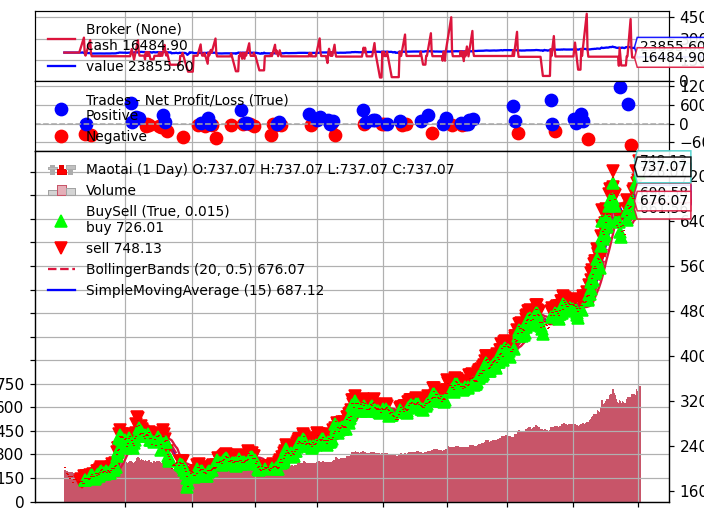

In [107]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  
import os.path  
import sys  

# 导入backtrader
import backtrader as bt
import numpy as np
import pymannkendall as mk

# 创建策略
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),('trend_test_period', 20), ("period", 20), ("devfactor", 0.5), ("debug", False), ("size", 1),
        ("trail", False), ("stop_loss", 0.02)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # 创建line对象，跟踪收盘价
        self.dataclose = self.datas[0].close
        self.data_trend_test = self.datas[0].get(size=self.p.trend_test_period)  # ago defaults to 0
        # 跟踪order
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #设置变点检验的区间
        #初始化布林线
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        # 导入移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order已经创建执行
            return

        # 钱不够的情况下Broker可以阻止order的创建
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.size))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # 打印持仓信息
        print(self.position)
        #进行趋势检验
        self.trend_test_data = self.data.get(size=self.params.trend_test_period)
        trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(self.trend_test_data)
        print(trend)
        #没有趋势时，用布林线法则
        if trend == 'no trend':
            print('没有趋势,使用布林线法则')
            #已经是多头的情形
            if self.position.size > 0:
                if self.data.close < self.boll.lines.bot:
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.order = self.buy()
                else:
                    self.log('close long, %.2f' % self.dataclose[0])
                    self.order = self.close()
            #已经是空头的情形
            if self.position.size < 0:
                if self.data.close > self.boll.lines.top:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell() 
                else:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.close()
            #还没有持仓的情形
            if self.position.size == 0:
                if self.data.close > self.boll.lines.top:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell() 
                else:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.buy()
        else:  
            print('有趋势,使用均线法则')
            if self.order:
                return
            #已经是多头的情形
            if self.position.size > 0:
                if self.dataclose[0] > self.sma[0]:
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.order = self.buy()
                if self.dataclose[0] > self.sma[0]:
                    self.log('close long, %.2f' % self.dataclose[0])
                    self.order = self.close()
            #已经是空头的情形
            if self.position.size < 0:
                if self.dataclose[0] > self.sma[0]:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.close()
                if self.dataclose[0] < self.sma[0]:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell()
            #还没有持仓的情形
            if self.position.size == 0:
                if self.dataclose[0] > self.sma[0]:
                    self.log('close short, %.2f' % self.dataclose[0])
                    self.order = self.buy()
                if self.dataclose[0] < self.sma[0]:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell()

if __name__ == '__main__':
    # 创建一个cerebro实体
    cerebro = bt.Cerebro()

    # 向实体中添加策略
    cerebro.addstrategy(TestStrategy)
    # 创建 Data Feed
    data = bt.feeds.GenericCSVData(
        dataname='D:\desktop\Maotai.csv',
        fromdate=datetime.datetime(2015, 1, 5),
        todate=datetime.datetime(2018, 1, 5),
        nullvalue=0.0,
        dtformat=('%Y-%m-%d'),
        datetime=0,
        open = 1,
        high = 2,
        low = 3,
        close = 4,
        volume =5, 
        openinterest=-1,
        reverse=False)

    # 在cerebro中添加数据
    cerebro.adddata(data)

    # 设置初始现金值
    cerebro.broker.setcash(20000.0)

    # 固定交易的手数
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # 设置交易手续费
    cerebro.broker.setcommission(commission=0.0)

    # 打印开始的金额
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # 运行
    cerebro.run()

    # 打印最终的金额
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(style='candlestick')

直接用布林线法则

直接用均线策略